# Setting up
Import libraries and graph data

In [1]:
import networkx as nx
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.clique import find_cliques
import pandas as pd
import numpy as np
import time
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from csv import writer
import glob

directory_path = "D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development"

# Loads network graph

Loads graph as-is then remove the isolated nodes

In [0]:
# Loads network data from graphml
# Warning: Node attributes will be string
graph_input_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/graph_outputs/ppa_r2_90_co_5.graphml"
ppa_graph = nx.read_graphml(graph_input_path)

# Remove isolated nodes
isolated = list(nx.isolates(ppa_graph))
ppa_graph.remove_nodes_from(isolated)
print(f"Number of nodes: {ppa_graph.number_of_nodes()}")
print(f"Number of edges: {ppa_graph.number_of_edges()}")

Number of nodes: 9966
Number of edges: 60718


Define helper methods and find all cliques of size k

In [0]:
all_cliques = list(nx.find_cliques(ppa_graph))
print(f"Number of cliques in network: {len(all_cliques)}")

def find_cliques_of_size_k(k):
  toReturn = []
  for clique in all_cliques:
    if (len(clique) == k):
      to_append = [ppa_graph.nodes[protein_num]['Simplified_protein_ID'] for protein_num in list(clique)]
      toReturn.append(to_append)
  return toReturn

# remove cliques that contain the same node more than once
def clean_clique(clique_list):
  clean_clique = []
  for clique in clique_list:
    repeat_set = set()
    for node in clique:
      repeat_set.add(node)
    if len(repeat_set) == len(clique):
      clean_clique.append(clique)
  return clean_clique

size_3_cliques = clean_clique(find_cliques_of_size_k(3))
size_4_cliques = clean_clique(find_cliques_of_size_k(4))

print(f"Number of cliques of size 3: {len(size_3_cliques)}")
print(f"Number of cliques of size 4: {len(size_4_cliques)}")

Number of cliques in network: 57372
Number of cliques of size 3: 3054
Number of cliques of size 4: 235


# Loading Validation Datasets

In [0]:
path_to_corum_complexes = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/data_sources/Corum/allComplexes.txt"
corum_complexes_dataframe = pd.read_csv(path_to_corum_complexes,sep='\t')
# Makes a numpy array of all unique proteins in Corum
all_corum_subunits = corum_complexes_dataframe["subunits(UniProt IDs)"].to_numpy()
all_corum_subunits_list = list(map(lambda x: x.split(";"),all_corum_subunits))
all_corum_proteins = np.unique(np.array([item for sublist in all_corum_subunits_list for item in sublist]))

huri_union_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/data_sources/Huri/HI-union-processed.csv"
huri_union_df = pd.read_csv(huri_union_path)
all_ids_in_huri = np.array(huri_union_df['Uniprot_Id_1'].tolist() + huri_union_df['Uniprot_Id_2'].tolist())
huri_combined = (huri_union_df["Uniprot_Id_1"] + ";" + huri_union_df["Uniprot_Id_2"]).to_numpy()
unique_ids_in_huri = np.unique(all_ids_in_huri)

# Load Common Util Functions

In [0]:
# to_verify: list to be checked where if each element is in verify_list
# verify_list: list to be checked against
# min_verify_count: the minimum amount of elements in to_verify that needs to 
# be in verify_list in order for to_verify to be considered verifiable
def is_verifiable(to_verify,verify_list,min_verify_count):
  count = 0
  for node in to_verify:
    if node in verify_list:
      count += 1
  return count >= min_verify_count

# Data Analysis: ProteomeHD

ProteomeHD Full Interaction. The data is 4 gb so it takes about 4 minutes to load

In [0]:
proteomeHD_all_pairs_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/data_sources/ProteomeHD/all_proteomeHD_pairs.csv"
proteomeHD_all_pairs_interactions_df = pd.read_csv(proteomeHD_all_pairs_interactions_df_path)

In [0]:
proteomeHD_all_pairs_interactions_df.describe()

In [0]:
proteomeHD_all_pairs_interactions_df_cutoff = proteomeHD_all_pairs_interactions_df[proteomeHD_all_pairs_interactions_df['r'] >= 0.5]

In [0]:
proteomeHD_all_pairs_interactions_df_cutoff = proteomeHD_all_pairs_interactions_df_cutoff[proteomeHD_all_pairs_interactions_df_cutoff['observations'] >= 5]

In [12]:
proteomeHD_all_pairs_interactions_df_cutoff.describe()

,r,r2,observations
count,3.522763e+06,3.522763e+06,3.522763e+06
mean,6.632259e-01,4.551272e-01,3.292085e+01
std,1.235261e-01,1.751424e-01,4.941992e+01
min,5.000001e-01,2.500001e-01,5.000000e+00
25%,5.593905e-01,3.129177e-01,7.000000e+00
50%,6.360998e-01,4.046229e-01,1.300000e+01
75%,7.466053e-01,5.574194e-01,3.200000e+01
max,9.999991e-01,9.999982e-01,2.940000e+02


In [0]:
cutoff_csv_save_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/data_sources/ProteomeHD/all_proteomeHD_pairs_cutoff_r_050_obs_5.csv"
proteomeHD_all_pairs_interactions_df_cutoff.to_csv(cutoff_csv_save_path)

Loading a random 100k samples from proteomeHD without validating

In [0]:
proteomeHD_interactions_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/proteomeHD/2_sample_100000_total_ver_1.csv"
proteomeHD_interactions_df = pd.read_csv(proteomeHD_interactions_path)

Summary Statistics:

In [0]:
print(pd.DataFrame.describe(proteomeHD_interactions_df['r']))
print(pd.DataFrame.describe(proteomeHD_interactions_df['r2']))
print(pd.DataFrame.describe(proteomeHD_interactions_df['observations']))

count    99983.000000
mean         0.005413
std          0.409044
min         -1.000000
25%         -0.217887
50%          0.000000
75%          0.228426
max          1.000000
Name: r, dtype: float64
count    99983.000000
mean         0.167345
std          0.260950
min          0.000000
25%          0.005258
50%          0.049838
75%          0.198446
max          1.000000
Name: r2, dtype: float64
count    100000.000000
mean         47.595750
std          58.392053
min           0.000000
25%           6.000000
50%          22.000000
75%          70.000000
max         293.000000
Name: observations, dtype: float64


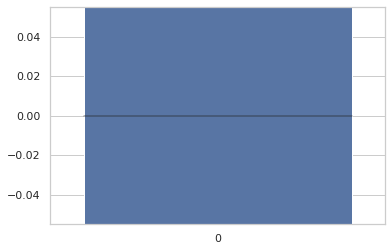

In [0]:
import seaborn as sns
sns.set(style="whitegrid")
sns.boxenplot(data=[proteomeHD_interactions_df['r'].to_numpy()])

## Data Analysis: ProteomeHD and Corum

Load up protein complexes from Corum

In [0]:
path_to_corum_complexes = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/data_sources/Corum/allComplexes.txt"
corum_complexes_dataframe = pd.read_csv(path_to_corum_complexes,sep='\t')
#corum_complexes_dataframe.head()

Get all unique proteins and all subunits from corum

In [0]:
# Makes a numpy array of all unique proteins in Corum
all_corum_subunits = corum_complexes_dataframe["subunits(UniProt IDs)"].to_numpy()
all_corum_subunits_list = list(map(lambda x: x.split(";"),all_corum_subunits))
all_corum_proteins = np.unique(np.array([item for sublist in all_corum_subunits_list for item in sublist]))

Calculate the amount of proteins that are both in Corum and proteomeHD

In [0]:
all_proteomeHD_proteins =  [ppa_graph.nodes[protein_num]['Simplified_protein_ID'] for protein_num in ppa_graph.nodes]
all_proteomeHD_proteins_np = np.array(all_proteomeHD_proteins)
proteomeHD_corum_overlap = np.intersect1d(all_corum_proteins,all_proteomeHD_proteins_np)

print(f"{len(proteomeHD_corum_overlap)} overlapping proteins between proteomeHD and corum")
print(f"{len(proteomeHD_corum_overlap)/len(all_proteomeHD_proteins)} of proteomeHD proteins")
print(f"{len(proteomeHD_corum_overlap)/len(all_corum_proteins)} of corum proteins")

2974 overlapping proteins between proteomeHD and corum
0.2984146096728878 of proteomeHD proteins
0.48499673842139596 of corum proteins


Check how many of th 3 cliques can actually be verified by Corum (verifiable when all proteins are also in Corum)

In [0]:
verifiable_3_cliques = []
for clique in size_3_cliques:
  if is_verifiable(clique,all_corum_proteins,len(clique)):
    verifiable_3_cliques.append(clique)

print(f"Number of verfiable 3-cliques in Corum: {len(verifiable_3_cliques)} ({len(verifiable_3_cliques)/len(size_3_cliques)} of all 3-clqiues)")

Number of verfiable 3-cliques in Corum: 72 (0.023575638506876228 of all 3-clqiues)


Similarly, we ask how many complexes in Corum can be verified by proteins in proteomeHD. We name the corum complexes containing at least 2 proteomeHD proteins pair-verifiable complexes, and those with at least 3 triplet-verifiable complexes

In [0]:
pair_verifiable_corum_complexes = []
triplet_verifiable_corum_complexes = []
for subunit in all_corum_subunits:
  to_verify = subunit.split(";")
  if (len(to_verify) >=2):
    if is_verifiable(to_verify,all_proteomeHD_proteins,2):
      pair_verifiable_corum_complexes.append(subunit)
  if (len(to_verify)>=3):
    if is_verifiable(to_verify,all_proteomeHD_proteins,3):
      triplet_verifiable_corum_complexes.append(subunit)
print(f"Corum complexes with >= 2 proteomeHD proteins: {len(pair_verifiable_corum_complexes)} ({len(pair_verifiable_corum_complexes)/len(all_corum_subunits)} of all corum complexes)")
print(f"Corum complexes with >= 3 proteomeHD proteins: {len(triplet_verifiable_corum_complexes)} ({len(triplet_verifiable_corum_complexes)/len(all_corum_subunits)} of all corum complexes)")

Corum complexes with >= 2 proteomeHD proteins: 2397 (0.560832943378568 of all corum complexes)
Corum complexes with >= 3 proteomeHD proteins: 1516 (0.3547028544688816 of all corum complexes)


### Check samples of validated proteomeHD interactions in Corum

Check the distribution of r, r2, and observations of validated interactions in Corum

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Comparing the distribution of r,r2,observations of
Validated Corrum interactions (top row)
Random samples from proteomeHD (bottom row)


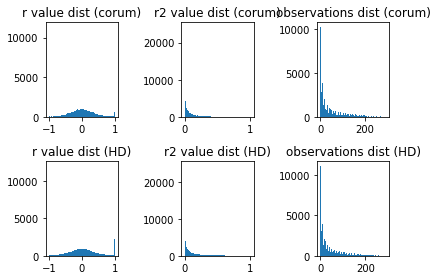

In [0]:
import matplotlib.pyplot as plt
validated_corum_interactions_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/proteomeHD_corum/overlap_1000_pos_99000_neg.csv"
validated_corum_interactions_df = pd.read_csv(validated_corum_interactions_path)
validated_corum_interactions_df = validated_corum_interactions_df[validated_corum_interactions_df["r2"] != 1]
fig, axs = plt.subplots(2, 3)
num_bins = 20
corum_r_values,_,_ = axs[0,0].hist(validated_corum_interactions_df['r'], num_bins)
axs[0,0].set_title('r value dist (corum)')
corum_r2_values,_,_ = axs[0,1].hist(validated_corum_interactions_df['r2'], num_bins)
axs[0,1].set_title('r2 value dist (corum)')
corum_observations_values,_,_ = axs[0,2].hist(validated_corum_interactions_df['observations'], num_bins)
axs[0,2].set_title('observations dist (corum)')
proteomeHD_r_values,_,_ = axs[1,0].hist(proteomeHD_interactions_df['r'], num_bins)
axs[1,0].set_title('r value dist (HD)')
proteomeHD_r2_values,_,_ = axs[1,1].hist(proteomeHD_interactions_df['r2'], num_bins)
axs[1,1].set_title('r2 value dist (HD)')
proteomeHD_observations_values,_,_ = axs[1,2].hist(proteomeHD_interactions_df['observations'], num_bins)
axs[1,2].set_title('observations dist (HD)')
plt.tight_layout()
print("Comparing the distribution of r,r2,observations of")
print("Validated Corrum interactions (top row)")
print("Random samples from proteomeHD (bottom row)")
plt.show()

Graph the distribution of pair verifiable corum complexes sizes

       ComplexSizes
count   2397.000000
mean       4.688778
std        6.036541
min        2.000000
25%        3.000000
50%        3.000000
75%        5.000000
max      143.000000


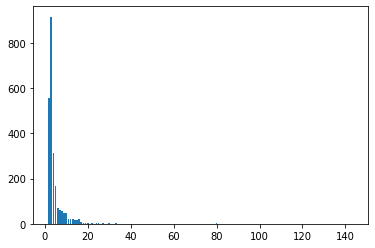

In [0]:
import matplotlib.pyplot as plt
from collections import Counter
pair_verifiable_corum_complexes_sizes = np.array(list(map(lambda x: len(x.split(";")),pair_verifiable_corum_complexes)))
size_counter_matrix = np.array(sorted(Counter(pair_verifiable_corum_complexes_sizes).items()))
print(pd.DataFrame.describe(pd.DataFrame(pair_verifiable_corum_complexes_sizes,columns=['ComplexSizes'])))
_= plt.bar(size_counter_matrix[:,0],size_counter_matrix[:,1])

We want to investigate the effect of complex size on the validation of proteomeHD protein pairs. In other words, given that a protein pair from proteomeHD is validated, what is the probability that the complex is got validated in has size n? 

We define a function where x = size of complex, y = number of possible pairs it can generate. Then graph the number of pairs all protein complex sizes can produce

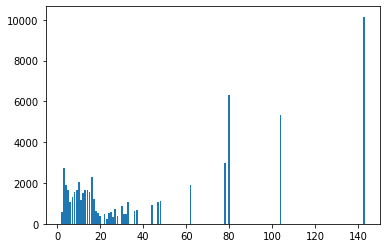

In [0]:
def n_choose_2(n):
  return int(n*(n-1)/2)
num_possible_pairs = []
for i in range(len(size_counter_matrix)):
  num_possible_pairs.append(n_choose_2(size_counter_matrix[i,0]) * int(size_counter_matrix[i,1]))
_ = plt.bar(size_counter_matrix[:,0],num_possible_pairs)

We discover that theoretically, over 50% of the validated protein pairs in proteomeHD will be validated by one of the 14 complexes of size 32 or above (0.5% of total complexes), while only 10% will be validated by one of the 1785 complexes of size 5 or below (74.5% of total complexes) 

In [0]:
cummulative_pair_sum = np.cumsum(num_possible_pairs)
all_possible_pairs_sum = np.sum(num_possible_pairs)
ratio_to_all_pairs = cummulative_pair_sum / all_possible_pairs_sum
below_size_5_complexes = np.sum(size_counter_matrix[0:np.argmax(size_counter_matrix[:,0]==5),1])
above_size_32_complexes = np.sum(size_counter_matrix[np.argmax(size_counter_matrix[:,0]==32):,1])
print(f"Number of complexes of size 5 or below: {below_size_5_complexes} ({below_size_5_complexes / len(pair_verifiable_corum_complexes)} of all pair verifiable complexes)")
print(f"Probability that a validated protein is in a complex of size 5 or below: {ratio_to_all_pairs[np.argmax(size_counter_matrix[:,0]==5)]}")
print(f"Number of complexes of size 32 or above: {above_size_32_complexes} ({above_size_32_complexes / len(pair_verifiable_corum_complexes)} of all pair verifiable complexes)")
print(f"Probability that a validated protein is in a complex of size 32 or above {1 - ratio_to_all_pairs[np.argmax(size_counter_matrix[:,0]==32)]}")

Number of complexes of size 5 or below: 1785 (0.7446808510638298 of all pair verifiable complexes)
Probability that a validated protein is in a complex of size 5 or below: 0.10670352882703778
Number of complexes of size 32 or above: 14 (0.005840634125990822 of all pair verifiable complexes)
Probability that a validated protein is in a complex of size 32 or above 0.5005902087475149


To verify this, we look at our empirical data distributioon

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0, 0.5, 'Validated Pairs')

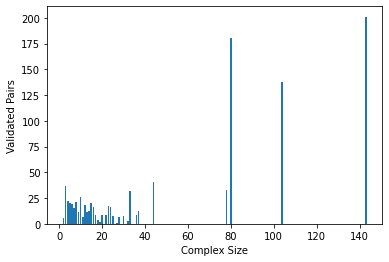

In [0]:
biased_proteomeHD_corum_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/proteomeHD_corum/overlap_1000_pos_99000_neg.csv"
biased_proteomeHD_corum_df = pd.read_csv(biased_proteomeHD_corum_path)
biased_proteomeHD_corum_df = biased_proteomeHD_corum_df[biased_proteomeHD_corum_df["r2"] != 1]
biased_proteomeHD_corum_validated_pairs = biased_proteomeHD_corum_df.dropna()["belong_to"].to_numpy()
biased_proteomeHD_corum_pairs_sizes = np.array(list(map(lambda x: len(x.split(";")),biased_proteomeHD_corum_validated_pairs)))
empirical_size_counter_matrix = np.array(sorted(Counter(biased_proteomeHD_corum_pairs_sizes).items()))
#print(empirical_size_counter_matrix)
#print(pd.DataFrame.describe(pd.DataFrame(empirical_size_counter_matrix[:,1],columns=['ComplexSizes'])))
_= plt.bar(empirical_size_counter_matrix[:,0],empirical_size_counter_matrix[:,1])
plt.xlabel("Complex Size")
plt.ylabel("Validated Pairs")

In [0]:
empirical_cummulative_pair_sum = np.cumsum(empirical_size_counter_matrix[:,1])
empirical_all_possible_pairs_sum = np.sum(empirical_size_counter_matrix[:,1])
empirical_ratio_to_all_pairs = empirical_cummulative_pair_sum / empirical_all_possible_pairs_sum
empirical_below_size_5_complexes = np.sum(size_counter_matrix[0:np.argmax(empirical_size_counter_matrix[:,0]==5),1])
empirical_above_size_32_complexes = np.sum(size_counter_matrix[np.argmax(empirical_size_counter_matrix[:,0]==32):,1])
print(f"Proportion of complex validated having size 5 or below: {empirical_ratio_to_all_pairs[np.argmax(empirical_size_counter_matrix[:,0]==5)]}")
print(f"Proportion of complex validated having size 32 or above {1 - empirical_ratio_to_all_pairs[np.argmax(empirical_size_counter_matrix[:,0]==32)]}")

Proportion of complex validated having size 5 or below: 0.1838955386289445
Proportion of complex validated having size 32 or above 0.5168661588683352


### Overall ProteomeHD Corum performance

In [0]:
proteomeHD_corum_validated_pairs_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/proteomeHD/corum_validated/has_validation.csv"
proteomeHD_corum_validated_pairs_df = pd.read_csv(proteomeHD_corum_validated_pairs_df_path)
#proteomeHD_corum_validated_pairs_df = proteomeHD_corum_validated_pairs_df[proteomeHD_corum_validated_pairs_df["r2"] < 0.99]
proteomeHD_corum_validated_non_pairs_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/proteomeHD/corum_validated/has_no_validation.csv"
proteomeHD_corum_validated_non_pairs_df = pd.read_csv(proteomeHD_corum_validated_non_pairs_df_path)
#proteomeHD_corum_validated_non_pairs_df = proteomeHD_corum_validated_non_pairs_df[proteomeHD_corum_validated_non_pairs_df["r2"] < 0.99]

In [0]:
proteomeHD_corum_validated_pairs_df

,protein1,protein2,r,r2,observations
0,P56524,P27361,-0.049762,0.002476,39
1,P56524,P28482,-0.052761,0.002784,43
2,P56524,P59768,0.250236,0.062618,9
3,P56524,P62873,0.045789,0.002097,42
4,Q09472,Q92793,0.139837,0.019554,94
...,...,...,...,...,...
36236,Q12802,Q16539,0.156922,0.024624,158
36237,Q12802,Q9NYL2,0.116803,0.013643,57
36238,Q16512,Q16539,0.330290,0.109092,191
36239,Q16512,Q9NYL2,-0.108800,0.011837,65


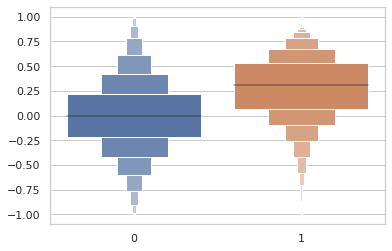

In [0]:
import seaborn as sns
sns.set(style="whitegrid")
sns.boxenplot(data=[proteomeHD_corum_validated_non_pairs_df["r"],proteomeHD_corum_validated_pairs_df["r"].to_numpy()])

### Case study: Cytoplasmic Ribosome

In [0]:
cytoplastic_ribosome_corum_validated_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/proteomeHD/corum_validated/cytoplasmic_ribosome.csv"
cytoplastic_ribosome_corum_validated_interactions_df = pd.read_csv(cytoplastic_ribosome_corum_validated_interactions_df_path)
#cytoplastic_ribosome_corum_validated_interactions_df = cytoplastic_ribosome_corum_validated_interactions_df[cytoplastic_ribosome_corum_validated_interactions_df["r2"] < 0.99]
non_cytoplastic_ribosome_corum_validated_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/proteomeHD/corum_validated/non_cytoplasmic_ribosome.csv"
non_cytoplastic_ribosome_corum_validated_interactions_df = pd.read_csv(non_cytoplastic_ribosome_corum_validated_interactions_df_path)
#non_cytoplastic_ribosome_corum_validated_interactions_df = non_cytoplastic_ribosome_corum_validated_interactions_df[non_cytoplastic_ribosome_corum_validated_interactions_df["r2"] < 0.99]

In [0]:
print(len(cytoplastic_ribosome_corum_validated_interactions_df))
print(len(non_cytoplastic_ribosome_corum_validated_interactions_df))

2926
32719


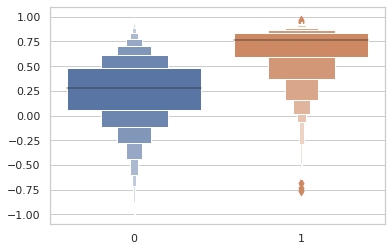

In [0]:
import seaborn as sns
sns.set(style="whitegrid")
sns.boxenplot(data=[non_cytoplastic_ribosome_corum_validated_interactions_df['r'],cytoplastic_ribosome_corum_validated_interactions_df["r"].to_numpy()])

## Data Analysis ProteomeHD and Huri

Load up proteins in Huri

In [0]:
proteomeHD_huri_overlap = np.intersect1d(all_proteomeHD_proteins_np,unique_ids_in_huri)
print(f"{len(proteomeHD_huri_overlap)} overlapping proteins between proteomeHD and huri")
print(f"{len(proteomeHD_huri_overlap)/len(all_proteomeHD_proteins)} of proteomeHD proteins")
print(f"{len(proteomeHD_huri_overlap)/len(all_ids_in_huri)} of huri proteins")

Check how many interactions in Huri are verifiable by proteomeHD (takes about 20 seconds to compute)

In [0]:
verifiable_huri_interactions = []
for proteins in huri_combined:
  to_verify = proteins.split(";")
  if is_verifiable(to_verify,all_proteomeHD_proteins,len(to_verify)):
    verifiable_huri_interactions.append(proteins)

print(f"Number of verfiable interactions in Huri: {len(verifiable_huri_interactions)} ({len(verifiable_huri_interactions)/len(huri_combined)} of total interactions in Huri)")

Number of verfiable interactions in Huri: 17210 (0.27806501648032056 of total interactions in Huri)


Check the distribution of r, r2, and observations of verifiable interactions in Huri

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Comparing the distribution of r,r2,observations of
Validated Huri interactions (top row)
Random samples from proteomeHD (bottom row)


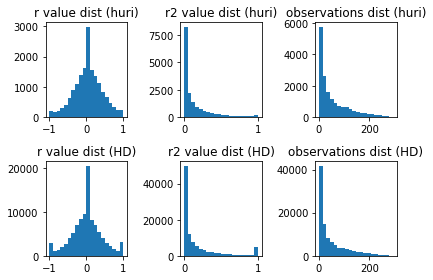

In [0]:
verifiable_interactions_stat_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/proteomeHD_huri_overlap/all_proteomeHD_verifiable_interactions_stats.csv"
verifiable_interactions_df = pd.read_csv(verifiable_interactions_stat_path)
verifiable_interactions_df = verifiable_interactions_df[verifiable_interactions_df["r2"] != 1]
fig, axs = plt.subplots(2, 3)
num_bins = 20
huri_r_values,_,_ = axs[0,0].hist(verifiable_interactions_df['r'], num_bins)
axs[0,0].set_title('r value dist (huri)')
huri_r2_values,_,_ = axs[0,1].hist(verifiable_interactions_df['r2'], num_bins)
axs[0,1].set_title('r2 value dist (huri)')
huri_observations_values,_,_ = axs[0,2].hist(verifiable_interactions_df['observations'], num_bins)
axs[0,2].set_title('observations dist (huri)')
proteomeHD_r_values,_,_ = axs[1,0].hist(proteomeHD_interactions_df['r'], num_bins)
axs[1,0].set_title('r value dist (HD)')
proteomeHD_r2_values,_,_ = axs[1,1].hist(proteomeHD_interactions_df['r2'], num_bins)
axs[1,1].set_title('r2 value dist (HD)')
proteomeHD_observations_values,_,_ = axs[1,2].hist(proteomeHD_interactions_df['observations'], num_bins)
axs[1,2].set_title('observations dist (HD)')
plt.tight_layout()
print("Comparing the distribution of r,r2,observations of")
print("Validated Huri interactions (top row)")
print("Random samples from proteomeHD (bottom row)")
plt.show()

Check the amount of "degenerate" interactions (having only 0 or 1 observation)

In [0]:
huri_degenerate_count = np.count_nonzero(verifiable_interactions_df['observations'].to_numpy() <= 1)
print(f"Number of degenerate interactions (only 0 or 1 observations): {huri_degenerate_count} ({huri_degenerate_count/len(verifiable_interactions_df)} of total)")
print(pd.DataFrame.describe(verifiable_interactions_df['r']))
print(pd.DataFrame.describe(verifiable_interactions_df['r2']))
print(pd.DataFrame.describe(verifiable_interactions_df['observations']))

Number of degenerate interactions (only 0 or 1 observations): 1314 (0.07635095874491575 of total)
count    17209.000000
mean         0.039379
std          0.406387
min         -1.000000
25%         -0.187735
50%          0.005755
75%          0.284730
max          1.000000
Name: r, dtype: float64
count    17209.000000
mean         0.166691
std          0.248913
min          0.000000
25%          0.008294
50%          0.057315
75%          0.206434
max          1.000000
Name: r2, dtype: float64
count    17210.000000
mean        53.933876
std         61.432494
min          0.000000
25%          8.000000
50%         28.000000
75%         82.000000
max        293.000000
Name: observations, dtype: float64


## Data Analysis ProteomeHD and String

In [0]:
string_proteomeHD_expression_csv_path = '/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/proteomeHD_string/string_proteomeHD_expression.csv'
string_proteomeHD_expression_df = pd.read_csv(string_proteomeHD_expression_csv_path)
#string_proteomeHD_expression_df = string_proteomeHD_expression_df[string_proteomeHD_expression_df["r2"] < 0.99]
string_proteomeHD_expression_df

,protein1,protein2,score,r,r2,observations
0,ENSP00000000233,ENSP00000222547,913,0.321928,0.103638,110
1,ENSP00000000233,ENSP00000223369,913,0.111527,0.012438,209
2,ENSP00000000233,ENSP00000249923,923,0.118915,0.014141,224
3,ENSP00000000233,ENSP00000258739,913,0.131740,0.017356,77
4,ENSP00000000233,ENSP00000262225,909,0.273858,0.074998,184
...,...,...,...,...,...,...
222637,ENSP00000485663,ENSP00000467466,950,0.411156,0.169050,227
222638,ENSP00000485663,ENSP00000470972,954,0.694228,0.481953,251
222639,ENSP00000485663,ENSP00000472469,955,0.738992,0.546109,224
222640,ENSP00000485663,ENSP00000472985,961,0.531892,0.282909,277


In [0]:
string_proteomeHD_expression_df.describe()

,score,r,r2,observations
count,218946.000000,218946.000000,218946.000000,218946.000000
mean,847.332237,0.175210,0.155875,105.888347
std,147.755844,0.353804,0.197958,86.293037
min,400.000000,-0.994987,0.000000,0.000000
25%,900.000000,-0.040847,0.014224,25.000000
50%,902.000000,0.176437,0.072726,89.000000
75%,914.000000,0.423928,0.223960,176.000000
max,996.000000,0.994913,0.989998,294.000000


In [0]:
control_unbiased_sampling_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/proteomeHD_string/overlap_200000_neg.csv"
control_unbiased_sampling_df = pd.read_csv(control_unbiased_sampling_path)
control_unbiased_sampling_df = control_unbiased_sampling_df[['r','r2','observations']]
control_unbiased_sampling_df = control_unbiased_sampling_df[control_unbiased_sampling_df['r2'] < 0.99]
print(len(control_unbiased_sampling_df))
control_unbiased_sampling_df.describe()

197983


,r,r2,observations
count,197983.000000,197983.000000,197983.000000
mean,0.002605,0.126264,57.567988
std,0.355328,0.191357,63.157319
min,-0.994969,0.000000,0.000000
25%,-0.207799,0.005895,9.000000
50%,0.000000,0.044009,31.000000
75%,0.212076,0.159202,89.000000
max,0.994943,0.989964,294.000000


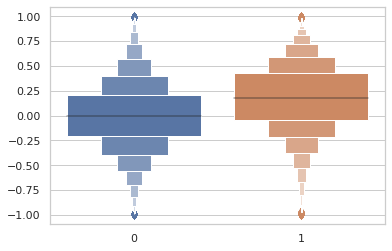

In [0]:
import seaborn as sns
sns.set(style="whitegrid")
sns.boxenplot(data=[control_unbiased_sampling_df['r'].to_numpy(),string_proteomeHD_expression_df['r'].to_numpy()])

# Data Analysis: pQTL

## Data Analysis: pQTL silac protein

In [0]:
pQTL_silac_protein_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/data_sources/pQTL/silac_protein/silac_protein_complete.csv"
pQTL_silac_protein_df = pd.read_csv(pQTL_silac_protein_df_path)
pQTL_silac_protein = pQTL_silac_protein_df["Uniprot_Id"].dropna().to_numpy()

## Data Analysis: pQTL protein and Corum

In [0]:
pQTL_silac_protein_verifiable_corum_complexes = []
for subunit in all_corum_subunits:
  to_verify = subunit.split(";")
  if (len(to_verify) >=2):
    if is_verifiable(to_verify,pQTL_silac_protein,2):
      pQTL_silac_protein_verifiable_corum_complexes.append(subunit)
print(len(pQTL_silac_protein_verifiable_corum_complexes))

1425


In [0]:
pQTL_silac_protein_corum_overlap = np.intersect1d(pQTL_silac_protein,all_corum_proteins)
print(f"{len(pQTL_silac_protein_corum_overlap)} overlapping proteins between pQTL silac proteins and corum")
print(f"{len(pQTL_silac_protein_corum_overlap)/len(pQTL_silac_protein)} of pQTL silac proteins")
print(f"{len(pQTL_silac_protein_corum_overlap)/len(all_corum_proteins)} of corum proteins")

1741 overlapping proteins between pQTL silac proteins and corum
0.08108611615667645 of pQTL proteins
0.2839204174820613 of corum proteins


In [0]:
pQTL_silac_protein_huri_overlap = np.intersect1d(pQTL_silac_protein,unique_ids_in_huri)
print(f"{len(pQTL_silac_protein_huri_overlap)} overlapping proteins between pQTL silac proteins and huri")
print(f"{len(pQTL_silac_protein_huri_overlap)/len(pQTL_silac_protein)} of pQTL silac proteins")
print(f"{len(pQTL_silac_protein_huri_overlap)/len(unique_ids_in_huri)} of huri proteins")

2343 overlapping proteins between pQTL and huri
0.10912393460947324 of pQTL proteins
0.26284496297958265 of huri proteins


In [0]:
pQTL_silac_protein_corum_validated_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/pQTL/silac_protein/corum_validated/has_validation.csv"
pQTL_silac_protein_corum_validated_interactions_df = pd.read_csv(pQTL_silac_protein_corum_validated_interactions_df_path)
pQTL_silac_protein_corum_validated_non_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/pQTL/silac_protein/corum_validated/has_no_validation.csv"
pQTL_silac_protein_corum_validated_non_interactions_df = pd.read_csv(pQTL_silac_protein_corum_validated_non_interactions_df_path)

In [0]:
len(pQTL_silac_protein_corum_validated_interactions_df)
#len(pQTL_silac_protein_corum_validated_non_interactions_df)

22510

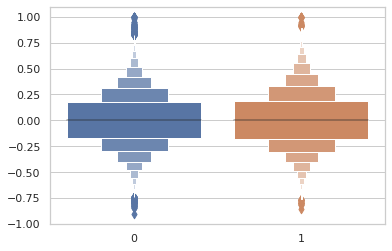

In [0]:
import seaborn as sns
sns.set(style="whitegrid")
sns.boxenplot(data=[pQTL_silac_protein_corum_validated_non_interactions_df["r"].to_numpy(),pQTL_silac_protein_corum_validated_interactions_df["r"].to_numpy()])

## pQTL silac protein and string

In [0]:
pQTL_silac_protein_string_validated_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/pQTL/silac_protein/string_validated/has_validation.csv"
pQTL_silac_protein_string_validated_interactions_df = pd.read_csv(pQTL_silac_protein_string_validated_interactions_df_path)
pQTL_silac_protein_string_validated_non_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/pQTL/silac_protein/string_validated/has_no_validation.csv"
pQTL_silac_protein_string_validated_non_interactions_df = pd.read_csv(pQTL_silac_protein_string_validated_non_interactions_df_path)
# pQTL_silac_protein_string_validated_interactions_df.describe()
# pQTL_silac_protein_string_validated_non_interactions_df.describe()

In [0]:
len(pQTL_silac_protein_string_validated_interactions_df)

98400

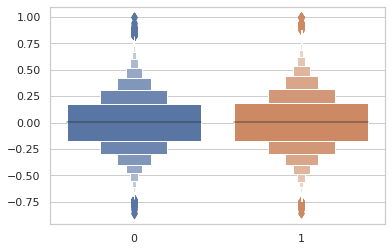

In [0]:
import seaborn as sns
sns.set(style="whitegrid")
sns.boxenplot(data=[pQTL_silac_protein_string_validated_non_interactions_df["r"],pQTL_silac_protein_string_validated_interactions_df['r'].to_numpy()])

## pQTL ribo and corum

In [0]:
pQTL_ribo_corum_validated_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/pQTL/ribo/corum_validated/has_validation.csv"
pQTL_ribo_corum_validated_interactions_df = pd.read_csv(pQTL_ribo_corum_validated_interactions_df_path)
pQTL_ribo_corum_validated_non_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/pQTL/ribo/corum_validated/has_no_validation.csv"
pQTL_ribo_corum_validated_non_interactions_df = pd.read_csv(pQTL_ribo_corum_validated_non_interactions_df_path)
pQTL_ribo_corum_validated_non_interactions_df.describe()

,r,r2,observations,is_validated,belong_to
count,100000.000000,1.000000e+05,100000.0,100000.0,0.0
mean,0.050918,5.476847e-02,72.0,0.0,NaN
std,0.228421,9.376282e-02,0.0,0.0,NaN
min,-0.696484,6.298983e-12,72.0,0.0,NaN
25%,-0.103553,4.838726e-03,72.0,0.0,NaN
50%,0.040344,2.150012e-02,72.0,0.0,NaN
75%,0.186339,6.325088e-02,72.0,0.0,NaN
max,1.000000,1.000000e+00,72.0,0.0,NaN


In [0]:
pQTL_ribo_corum_validated_interactions_df.describe()

,r,r2,observations
count,22510.000000,2.251000e+04,22510.0
mean,0.056018,6.090835e-02,72.0
std,0.240360,1.033387e-01,0.0
min,-0.681389,3.507214e-11,72.0
25%,-0.108661,5.394317e-03,72.0
50%,0.042367,2.414231e-02,72.0
75%,0.198519,7.071053e-02,72.0
max,1.000000,1.000000e+00,72.0


In [0]:
print(len(pQTL_ribo_corum_validated_interactions_df))
print(len(pQTL_ribo_corum_validated_non_interactions_df))

22510
100000


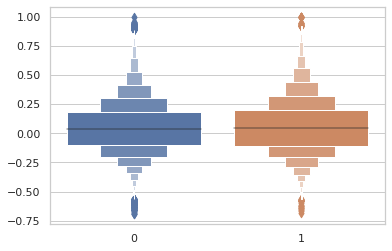

In [0]:
import seaborn as sns
sns.set(style="whitegrid")
sns.boxenplot(data=[pQTL_ribo_corum_validated_non_interactions_df["r"].to_numpy(),pQTL_ribo_corum_validated_interactions_df["r"].to_numpy()])

## pQTL ribo and string

In [0]:
pQTL_ribo_string_validated_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/pQTL/ribo/string_validated/has_validation.csv"
pQTL_ribo_string_validated_interactions_df = pd.read_csv(pQTL_ribo_string_validated_interactions_df_path)
pQTL_ribo_string_validated_non_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/pQTL/ribo/string_validated/has_no_validation.csv"
pQTL_ribo_string_validated_non_interactions_df = pd.read_csv(pQTL_ribo_string_validated_non_interactions_df_path)
pQTL_ribo_string_validated_interactions_df.describe()

In [0]:
print(len(pQTL_ribo_string_validated_interactions_df))
print(len(pQTL_ribo_string_validated_non_interactions_df))

98400
100000


In [0]:
pQTL_ribo_string_validated_non_interactions_df.describe()

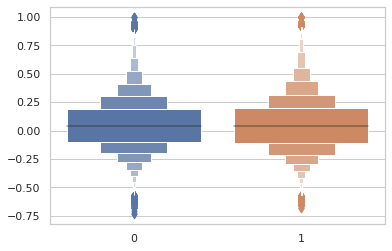

In [0]:
import seaborn as sns
sns.set(style="whitegrid")
sns.boxenplot(data=[pQTL_ribo_string_validated_non_interactions_df["r"],pQTL_ribo_string_validated_interactions_df['r'].to_numpy()])

## pQTL rna-seq and corum

In [0]:
pQTL_rna_seq_corum_validated_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/pQTL/rna_seq/corum_validated/has_validation.csv"
pQTL_rna_seq_corum_validated_interactions_df = pd.read_csv(pQTL_rna_seq_corum_validated_interactions_df_path)
pQTL_rna_seq_corum_validated_non_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/pQTL/rna_seq/corum_validated/has_no_validation.csv"
pQTL_rna_seq_corum_validated_non_interactions_df = pd.read_csv(pQTL_rna_seq_corum_validated_non_interactions_df_path)

In [0]:
pQTL_rna_seq_corum_validated_interactions_df.describe()

,r,r2,observations
count,22510.000000,2.251000e+04,22510.0
mean,0.050467,7.724004e-02,75.0
std,0.273307,1.115885e-01,0.0
min,-0.802062,2.342845e-11,75.0
25%,-0.127823,6.479710e-03,75.0
50%,0.041997,3.073798e-02,75.0
75%,0.221859,1.000741e-01,75.0
max,1.000000,1.000000e+00,75.0


In [0]:
print(len(pQTL_rna_seq_corum_validated_interactions_df))
print(len(pQTL_rna_seq_corum_validated_non_interactions_df))

22510
100000


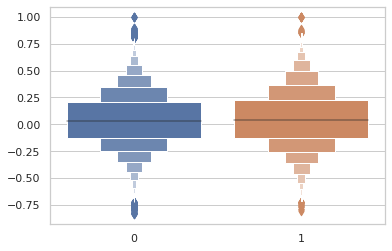

In [0]:
import seaborn as sns
sns.set(style="whitegrid")
sns.boxenplot(data=[pQTL_rna_seq_corum_validated_non_interactions_df["r"],pQTL_rna_seq_corum_validated_interactions_df["r"].to_numpy()])

## pQTL rna-seq and string

In [0]:
pQTL_rna_seq_string_validated_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/pQTL/rna_seq/string_validated/has_validation.csv"
pQTL_rna_seq_string_validated_interactions_df = pd.read_csv(pQTL_rna_seq_string_validated_interactions_df_path)
pQTL_rna_seq_string_validated_non_interactions_df_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/pQTL/rna_seq/string_validated/has_no_validation.csv"
pQTL_rna_seq_string_validated_non_interactions_df = pd.read_csv(pQTL_rna_seq_string_validated_non_interactions_df_path)
pQTL_rna_seq_string_validated_interactions_df.describe()

,score,r,r2,observations
count,98400.000000,98400.000000,9.840000e+04,98400.0
mean,868.242175,0.043252,7.528457e-02,75.0
std,134.208245,0.270951,1.098716e-01,0.0
min,400.000000,-0.856915,6.611175e-11,75.0
25%,900.000000,-0.134772,6.588620e-03,75.0
50%,904.000000,0.033403,2.992628e-02,75.0
75%,928.000000,0.213136,9.535932e-02,75.0
max,996.000000,1.000000,1.000000e+00,75.0


In [0]:
print(len(pQTL_rna_seq_string_validated_interactions_df))
print(len(pQTL_rna_seq_string_validated_non_interactions_df))

98400
100000


In [0]:
pQTL_rna_seq_string_validated_non_interactions_df.describe()

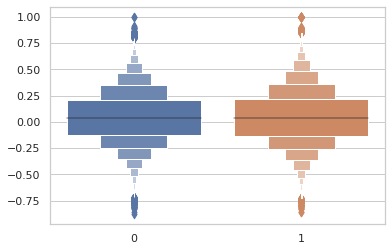

In [0]:
import seaborn as sns
sns.set(style="whitegrid")
sns.boxenplot(data=[pQTL_rna_seq_string_validated_non_interactions_df["r"],pQTL_rna_seq_string_validated_interactions_df['r'].to_numpy()])

# Defining hit,precision, and recall
- hit: When the proteins in a clique is subset of a protein subunits in a protein complex in the Corum dataset
- precision: Number of hitting cliques / total number of cliques
- recall: Number of complexes hit by cliques / total number of complexes


In [0]:
# Checks if a given clique (tuple or list) is a hit
# When the proteins in the clique is a subset of a protein subunits in a protein
# complex in the Corum dataset
def is_hit(clique):
  for subunit in all_corum_subunits:
    in_amount = 0
    for protein in clique:
      if(protein in subunit):
        # print(str(protein) + " is in " + str(subunit))
        in_amount += 1
    if(in_amount == len(clique)):
      print("hit!!!")
      print(str(clique) + " is in " + str(subunit))
      return True
  return False

# Calculates the precision of the given list of cliques
# precison = number of hitting cliques / total number of cliques
def calc_precision(cliques):
  hit_num = 0
  for clique in cliques:
    if(is_hit(clique)):
      hit_num += 1
  return hit_num / len(cliques)
  #return hit_num

# Checks what complexes this clique hit
# return a vector of True and False indicating complex it hits
def check_hits(clique):
  one_hot = np.full(len(all_corum_subunits), False, dtype=bool)
  for subunit_index in range(len(all_corum_subunits)):
    subunit = all_corum_subunits[subunit_index]
    in_amount = 0
    for protein in clique:
      if(protein in subunit):
        in_amount += 1
    if(in_amount == len(clique)):
      one_hot.itemset(subunit_index,True)
  return one_hot

# Calculates the recall of the given cliques
# recall = Number of complexes hit by cliques / total number of complexes
def calc_recall(cliques):
  one_hot = np.full(len(all_corum_subunits), False, dtype=bool)
  for clique in cliques:
    one_hot = np.logical_or(one_hot,check_hits(clique))
  return np.count_nonzero(one_hot) / len(all_corum_subunits)

In [0]:
# Little test if the method works as intended
is_hit(['P41182','Q9UQL6'])
calc_recall(['P41182','Q9UQL6'])

hit!!!
['P41182', 'Q9UQL6'] is in P41182;Q9UQL6


0.2653252222742162

# Precision and Recall of current network cliques

In [0]:
print("Network Precision:")
network_precision = calc_precision(verifiable_3_cliques)
print(network_precision)
print("Network Recall:")
network_recall = calc_recall(verifiable_3_cliques)
print(network_recall)

Network Precision:
0.0
Network Recall:
0.0


# Precision and Recall of control

Defines helper functions and looks at all proteomeHD proteins

In [0]:
# Helper function that generates a list of list of human proteins of fixed size
def generate_cliques(clique_size,total,dataset):
  to_return = []
  for i in range(total):
    to_return.append(np.random.choice(dataset, clique_size, replace=False).tolist())
  return to_return

# Calculates the average precision and recall over repeated trials of
# randomly generated cliques from proteins in given dataset
def calc_control(clique_size,total,repeat,dataset):
  total_precision = 0
  total_recall = 0
  for i in range(repeat):
    cliques = generate_cliques(clique_size,total,dataset)
    total_precision += calc_precision(cliques)
    print(total_precision)
    total_recall += calc_recall(cliques)
    print(total_recall)
  final_precision = total_precision / repeat
  final_recall = total_recall / repeat
  return final_precision,final_recall

Runs the computation

In [0]:
# Does the computation (takes about 15 minutes with parameter 3,3056,100)
# Result is 0 on both cases
start_time = time.time()

# control_precision,control_recall = calc_control(3,3056,100,all_human_proteins)
# Result: Precision: 0, Recall: 0 Time spent: 861

# control_precision,control_recall = calc_control(3,10000,1,all_human_proteins)
# Result: Precision: 0, Recall: 0 Time spent: 28

# control_precision,control_recall = calc_control(3,1000,10,all_human_proteins)
# Result: Precision: 0, Recall: 0 Time spent: 28

# control_precision,control_recall = calc_control(3,100,1000,all_human_proteins)
# Result: Precision: 0, Recall: 0 Time spent: 282

# control_precision,control_recall = calc_control(3,100,1000,all_proteomeHD_proteins)
# Result: Precision: 0, Recall: 0 Time spent: 282

# control_precision,control_recall = calc_control(3,3056,100,all_proteomeHD_proteins)
# Result: Precision: ~0 (1 hit), Recall: ~0 Time spent: 1095

control_precision,control_recall = calc_control(3,72,1000,all_corum_proteins)

print(time.time()-start_time)
print("Control Precision:")
print(control_precision)
print("Control Recall:")
print(control_recall)

# ROC Curve Construction: Model

Define function that returns ROC AUC and draws the ROC Curve

In [18]:
def calc_roc_auc(r_vector,r2_vector,observations_vector,normalized_manhattan_vector,test_y):
  no_skill_prob = np.zeros(len(r_vector))
  no_skill_auc = roc_auc_score(test_y, no_skill_prob)
  r_auc = roc_auc_score(test_y, r_vector)
  r2_auc = roc_auc_score(test_y, r2_vector)
  observation_auc = roc_auc_score(test_y, observations_vector)
  normalized_manhattan_auc = roc_auc_score(test_y, normalized_manhattan_vector)
  return no_skill_auc,r_auc,r2_auc,observation_auc,normalized_manhattan_auc

def draw_roc_curve(r_vector,r2_vector,observations_vector,normalized_manhattan_vector,test_y,sample_source,validation_source):
  no_skill_vector = np.zeros(len(r_vector))
  # calculate roc curves
  no_skill_fpr, no_skill_tpr, _ = roc_curve(test_y, no_skill_vector)
  r_fpr, r_tpr, _ = roc_curve(test_y, r_vector)
  r2_fpr, r2_tpr, _ = roc_curve(test_y, r2_vector)
  observation_fpr, observation_tpr, _ = roc_curve(test_y, observations_vector)
  manhattan_fpr, manhattan_tpr, _ = roc_curve(test_y, normalized_manhattan_vector)
  no_skill_auc,r_auc,r2_auc,observation_auc,manhattan_auc = calc_roc_auc(r_vector,r2_vector,observations_vector,normalized_manhattan_vector,test_y)
  # summarize scores
  print('No Skill: ROC AUC=%.3f' % (no_skill_auc))
  print('r: ROC AUC=%.3f' % (r_auc))
  print('r2: ROC AUC=%.3f' % (r2_auc))
  print('observation: ROC AUC=%.3f' % (observation_auc))
  print('Norm. Manhattan: ROC AUC=%.3f' % (manhattan_auc))
  # plot the roc curve for the model
  pyplot.plot(no_skill_fpr, no_skill_tpr, linestyle='--', label='No Skill AUC={auc}'.format(auc=no_skill_auc))
  pyplot.plot(r_fpr, r_tpr, marker='.', label='r AUC={auc}'.format(auc=r_auc))
  pyplot.plot(r2_fpr, r2_tpr, marker='.', label='r2 AUC={auc}'.format(auc=r2_auc))
  pyplot.plot(observation_fpr, observation_tpr, marker='s', label='Observations AUC={auc}'.format(auc=observation_auc))
  pyplot.plot(manhattan_fpr, manhattan_tpr, marker='*', label='Norm. Manhattan AUC={auc}'.format(auc=manhattan_auc))
  # axis labels
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  pyplot.title(f'ROC Curve of {sample_source}, validated against {validation_source}')
  # show the legend
  pyplot.legend()
  # show the plot
  pyplot.show()

def convert_nan_to_zero(vector):
  nan_indices = np.isnan(vector)
  vector[nan_indices] = 0
  return vector

def convert_nan_to_one(vector):
  nan_indices = np.isnan(vector)
  vector[nan_indices] = 1
  return vector

# Given dataframe with column named r,r2,observations and is_validated
# return auc of each and draws roc curve
def df_roc_analysis(df,df_sample_source,df_validation_source):
  r_vector = convert_nan_to_zero(df['r'].to_numpy())
  r2_vector = convert_nan_to_zero(df['r2'].to_numpy())
  observation_vector = df['observations'].to_numpy()
  normalized_manhattan_vector = 1 - convert_nan_to_one(df['normalized_manhattan_distance'].to_numpy())
  test_y = df['is_validated'].to_numpy()
  draw_roc_curve(r_vector,r2_vector,observation_vector,normalized_manhattan_vector,test_y,df_sample_source,df_validation_source)

Checking ROC Curve using samples generated from overlap between proteomeHD and corum

In [0]:
proteomeHD_corum_overlap_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/proteomeHD_corum/overlap_1000_pos_99000_neg.csv"
proteomeHD_corum_overlap_df = pd.read_csv(proteomeHD_corum_overlap_path)
print(f"Total validated corum protein pairs:{len(proteomeHD_corum_overlap_df[proteomeHD_corum_overlap_df['is_validated'] == 1])}")

Total validated corum protein pairs:1000


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
proteomeHD_corum_overlap_df_unvalidated = proteomeHD_corum_overlap_df[proteomeHD_corum_overlap_df["is_validated"] == 0]
proteomeHD_corum_overlap_df_validated = proteomeHD_corum_overlap_df[proteomeHD_corum_overlap_df["is_validated"] == 1]
proteomeHD_corum_overlap_df_unvalidated.describe()

,r,r2,observations,is_validated
count,98981.000000,98981.000000,99000.000000,99000.0
mean,0.004408,0.139866,54.307475,0.0
std,0.373963,0.215550,63.228753,0.0
min,-1.000000,0.000000,0.000000,0.0
25%,-0.211430,0.005483,7.000000,0.0
50%,0.000000,0.045967,26.000000,0.0
75%,0.217846,0.172085,82.000000,0.0
max,1.000000,1.000000,294.000000,0.0


In [0]:
proteomeHD_corum_overlap_df_validated.describe()

,r,r2,observations,is_validated
count,1000.000000,1000.000000,1000.00000,1000.0
mean,0.309050,0.227789,154.86100,1.0
std,0.363882,0.228790,93.92808,0.0
min,-1.000000,0.000000,0.00000,1.0
25%,0.073216,0.031777,66.00000,1.0
50%,0.347053,0.152132,163.00000,1.0
75%,0.591782,0.367415,246.00000,1.0
max,0.964358,1.000000,294.00000,1.0


No Skill: ROC AUC=0.500
r: ROC AUC=0.730
r2: ROC AUC=0.651
observation: ROC AUC=0.806


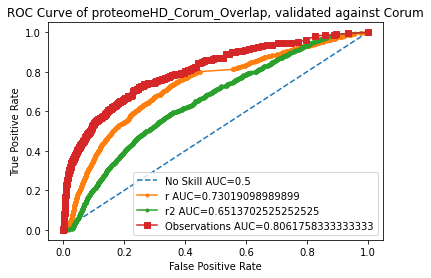

In [0]:
df_roc_analysis(proteomeHD_corum_overlap_df,"proteomeHD_Corum_Overlap","Corum")

Similarly for proteomeHD and Huri

In [0]:
proteomeHD_huri_overlap_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/proteomeHD_huri/overlap_1000_pos_99000_neg.csv"
proteomeHD_huri_overlap_df = pd.read_csv(proteomeHD_huri_overlap_path)
print(f"Total validated corum protein pairs:{len(proteomeHD_huri_overlap_df[proteomeHD_huri_overlap_df['is_validated'] == 1])}")

Total validated corum protein pairs:1000


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


No Skill: ROC AUC=0.500
r: ROC AUC=0.548
r2: ROC AUC=0.524
observation: ROC AUC=0.516


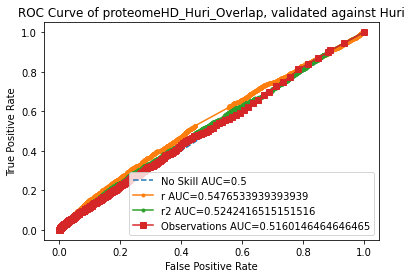

In [0]:
df_roc_analysis(proteomeHD_huri_overlap_df,"proteomeHD_Huri_Overlap","Huri")

Similarly for pQTL silac protein and corum

In [0]:
pQTL_corum_overlap_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/pQTL/silac_protein/corum_validated/overlap_1000_pos_99000_neg.csv"
pQTL_corum_overlap_df = pd.read_csv(pQTL_corum_overlap_path)
print(f"Total validated pQTL protein pairs:{len(pQTL_corum_overlap_df[pQTL_corum_overlap_df['is_validated'] == 1])}")

Total validated pQTL protein pairs:999


In [0]:
pQTL_corum_overlap_df_validated =pQTL_corum_overlap_df[pQTL_corum_overlap_df["is_validated"] == 1]
pQTL_corum_overlap_df_validated_non =pQTL_corum_overlap_df[pQTL_corum_overlap_df["is_validated"] == 0]
pQTL_corum_overlap_df_validated_non.describe()

,r,r2,observations,is_validated
count,99000.000000,9.900000e+04,99000.000000,99000.0
mean,0.022673,8.492351e-02,54.310606,0.0
std,0.290534,1.147078e-01,10.145274,0.0
min,-0.875296,1.393200e-11,10.000000,0.0
25%,-0.176363,8.479551e-03,48.000000,0.0
50%,0.016319,3.806056e-02,60.000000,0.0
75%,0.214953,1.145785e-01,62.000000,0.0
max,0.927732,8.606872e-01,62.000000,0.0


In [0]:
pQTL_corum_overlap_df_validated.describe()

,r,r2,observations,is_validated
count,999.000000,9.990000e+02,999.000000,999.0
mean,0.449995,3.055563e-01,58.955956,1.0
std,0.321191,2.566019e-01,6.881917,0.0
min,-0.583247,4.633245e-07,21.000000,1.0
25%,0.237926,6.810044e-02,60.000000,1.0
50%,0.490778,2.446417e-01,62.000000,1.0
75%,0.706839,4.996214e-01,62.000000,1.0
max,0.992092,9.842460e-01,62.000000,1.0


No Skill: ROC AUC=0.500
r: ROC AUC=0.834
r2: ROC AUC=0.775
observation: ROC AUC=0.652


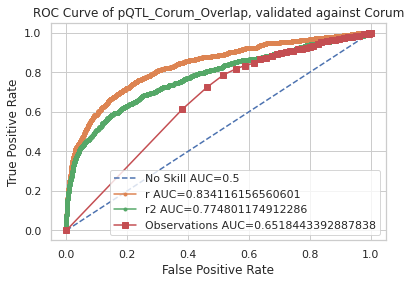

In [0]:
df_roc_analysis(pQTL_corum_overlap_df,"pQTL_Corum_Overlap","Corum")

pQTL silac protien and huri

In [0]:
pQTL_huri_overlap_path = "/content/drive/My Drive/Colab Notebooks/Research/ProteinProteinAssociation/csv_outputs/pQTL_huri/overlap_1000_pos_99000_neg.csv"
pQTL_huri_overlap_df = pd.read_csv(pQTL_huri_overlap_path)
print(f"Total validated pQTL protein pairs:{len(pQTL_huri_overlap_df[pQTL_huri_overlap_df['is_validated'] == 1])}")

Total validated pQTL protein pairs:999


No Skill: ROC AUC=0.500
r: ROC AUC=0.580
r2: ROC AUC=0.519
observation: ROC AUC=0.499


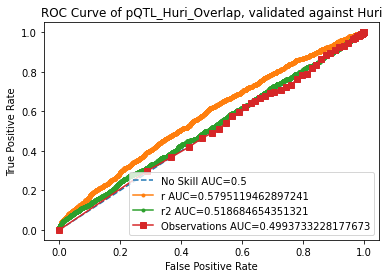

In [0]:
df_roc_analysis(pQTL_huri_overlap_df,"pQTL_Huri_Overlap","Huri")

No Skill: ROC AUC=0.500
r: ROC AUC=0.655
r2: ROC AUC=0.580
observation: ROC AUC=0.702
Norm. Manhattan: ROC AUC=0.689


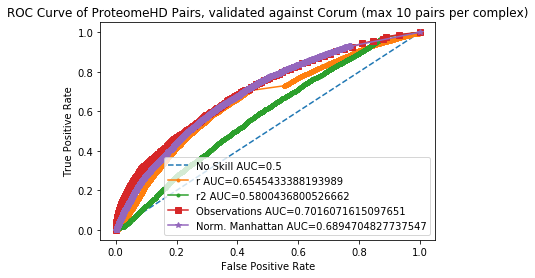

In [19]:
corum_complex_pairs_df_path = f"{directory_path}/data_sources/ProteomeHD/corum_validated/combined_max_10_pairs_per_complex.csv"
corum_complex_pairs_df = pd.read_csv(corum_complex_pairs_df_path)
df_roc_analysis(corum_complex_pairs_df,"ProteomeHD Pairs","Corum (max 10 pairs per complex)")